In [55]:
import pandas as pd
from sqlalchemy import create_engine
from config import PG_CONFIG
import logging
from datetime import datetime
import requests
from io import StringIO
import psycopg2
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
logging.basicConfig(
    filename=f"logs/etl_{datetime.now().strftime('%Y%m%d_%H%M')}.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logging.info("ETL progress started.")

In [3]:
url = "https://data.cityofchicago.org/api/views/gumc-mgzr/rows.csv?accessType=DOWNLOAD"

response = requests.get(url, verify=True) 
response.raise_for_status()

df = pd.read_csv(StringIO(response.text))
print(df.head())
print(len(df))


  CASE_NUMBER                    DATE               BLOCK  \
0    JF167335  03/08/2022 03:27:00 PM  6000 N KENMORE AVE   
1    JG148375  02/11/2023 02:30:00 AM   8400 S WABASH AVE   
2    JH242715  04/28/2024 10:54:00 PM   8800 S BURLEY AVE   
3    JH277922  05/25/2024 12:35:00 AM  5800 S PRAIRIE AVE   
4    JJ293685  06/13/2025 11:41:00 PM   100 N LARAMIE AVE   

  VICTIMIZATION_PRIMARY INCIDENT_PRIMARY GUNSHOT_INJURY_I          UNIQUE_ID  \
0              HOMICIDE         HOMICIDE               NO    HOM-JF167335-#1   
1              HOMICIDE         HOMICIDE              YES    HOM-JG148375-#1   
2              HOMICIDE         HOMICIDE              YES    HOM-JH242715-#1   
3               BATTERY          BATTERY              YES  SHOOT-JH277922-#1   
4              HOMICIDE         HOMICIDE              YES    HOM-JJ293685-#1   

   ZIP_CODE  WARD   COMMUNITY_AREA  ... MONTH  DAY_OF_WEEK  HOUR  \
0   60660.0  48.0        EDGEWATER  ...     3            3    15   
1   60619.0   6.

C:\Users\arzu_\AppData\Local\Temp\ipykernel_20584\158151422.py:6: DtypeWarning: Columns (25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text))


In [4]:
def get_engine():
    conn_url = (
        f"postgresql+psycopg2://{PG_CONFIG['user']}:{PG_CONFIG['password']}"
        f"@{PG_CONFIG['host']}:{PG_CONFIG['port']}/{PG_CONFIG['database']}"
    )
    return create_engine(conn_url)

engine = get_engine()

In [6]:
df.to_sql(
    "violence_victims_raw",
    engine,
    if_exists="replace",
    index=False,
    chunksize=5000,
    method="multi"
)

logging.info("Data was successfully loaded into PostgreSQL.")
print("ETL completed successfully.")

ETL completed successfully.


In [56]:
conn = psycopg2.connect(
    host="localhost",      
    database="postgres",  
    user="postgres",       
    password="1"    
)
query = "SELECT * FROM public.violence_victims_raw;"

df = pd.read_sql_query(query, conn)
conn.close()

print("Info about data")
display(df.head())

print("DataFrame shape:", df.shape)
print("\nInfo about columns:", df.columns)
print("\nThe first 5 lines:\n", df.head())
print("\nInfo about missing values:\n", df.isna().sum())
print("\nStatistics:\n", df.describe())
print("\nInfo about column types:\n", df.dtypes)
print("\nInfo:\n",df.info())


C:\Users\arzu_\AppData\Local\Temp\ipykernel_20584\240075426.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Info about data


,CASE_NUMBER,DATE,BLOCK,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,GUNSHOT_INJURY_I,UNIQUE_ID,ZIP_CODE,WARD,COMMUNITY_AREA,...,LONGITUDE,LOCATION,yearmonthday_char,yearmonth_char,year_char,month_char,day_char,time_only,imported_at,source_url
0,JJ438338,10/03/2025 03:42:00 PM,5400 S WELLS ST,HOMICIDE,HOMICIDE,NO,HOM-JJ438338-#1,NaN,NaN,None,...,NaN,None,20251003,202510,2025,10,03,15:42:00,2025-12-11 20:40:43.580448+00:00,https://data.cityofchicago.org/api/views/gumc-...
1,JJ458730,10/20/2025 02:26:00 PM,200 E 68TH ST,BATTERY,BATTERY,YES,SHOOT-JJ458730-#2,NaN,NaN,None,...,NaN,None,20251020,202510,2025,10,20,14:26:00,2025-12-11 20:40:43.580448+00:00,https://data.cityofchicago.org/api/views/gumc-...
2,JB209199,04/01/2018 04:00:00 AM,3300 W MONTROSE AVE,ROBBERY,ROBBERY,YES,SHOOT-JB209199-#1,60618.0,33.0,IRVING PARK,...,-87.712239,POINT (-87.712239058699 41.961523095858),20180401,201804,2018,04,01,04:00:00,2025-12-11 20:40:43.580448+00:00,https://data.cityofchicago.org/api/views/gumc-...
3,JJ403742,09/05/2025 11:55:00 PM,4000 W LAKE ST,BATTERY,BATTERY,YES,SHOOT-JJ403742-#1,60624.0,28.0,WEST GARFIELD PARK,...,-87.725965,POINT (-87.72596465388 41.885568345858),20250905,202509,2025,09,05,23:55:00,2025-12-11 20:40:43.580448+00:00,https://data.cityofchicago.org/api/views/gumc-...
4,JJ396834,08/31/2025 05:04:00 PM,1500 S CHRISTIANA AVE,BATTERY,BATTERY,YES,SHOOT-JJ396834-#1,60623.0,24.0,NORTH LAWNDALE,...,-87.709021,POINT (-87.709020941301 41.859746904142),20250831,202508,2025,08,31,17:04:00,2025-12-11 20:40:43.580448+00:00,https://data.cityofchicago.org/api/views/gumc-...


DataFrame shape: (62924, 46)

Info about columns: Index(['CASE_NUMBER', 'DATE', 'BLOCK', 'VICTIMIZATION_PRIMARY',
       'INCIDENT_PRIMARY', 'GUNSHOT_INJURY_I', 'UNIQUE_ID', 'ZIP_CODE', 'WARD',
       'COMMUNITY_AREA', 'STREET_OUTREACH_ORGANIZATION', 'AREA', 'DISTRICT',
       'BEAT', 'AGE', 'SEX', 'RACE', 'VICTIMIZATION_FBI_CD', 'INCIDENT_FBI_CD',
       'VICTIMIZATION_FBI_DESCR', 'INCIDENT_FBI_DESCR',
       'VICTIMIZATION_IUCR_CD', 'INCIDENT_IUCR_CD',
       'VICTIMIZATION_IUCR_SECONDARY', 'INCIDENT_IUCR_SECONDARY',
       'HOMICIDE_VICTIM_FIRST_NAME', 'HOMICIDE_VICTIM_MI',
       'HOMICIDE_VICTIM_LAST_NAME', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
       'LOCATION_DESCRIPTION', 'STATE_HOUSE_DISTRICT', 'STATE_SENATE_DISTRICT',
       'UPDATED', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'yearmonthday_char',
       'yearmonth_char', 'year_char', 'month_char', 'day_char', 'time_only',
       'imported_at', 'source_url'],
      dtype='object')

The first 5 lines:
   CASE_NUMBER                    DA

C:\Users\arzu_\AppData\Local\Temp\ipykernel_20584\970167570.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index('incident_timestamp').resample('M').size().rename('count')


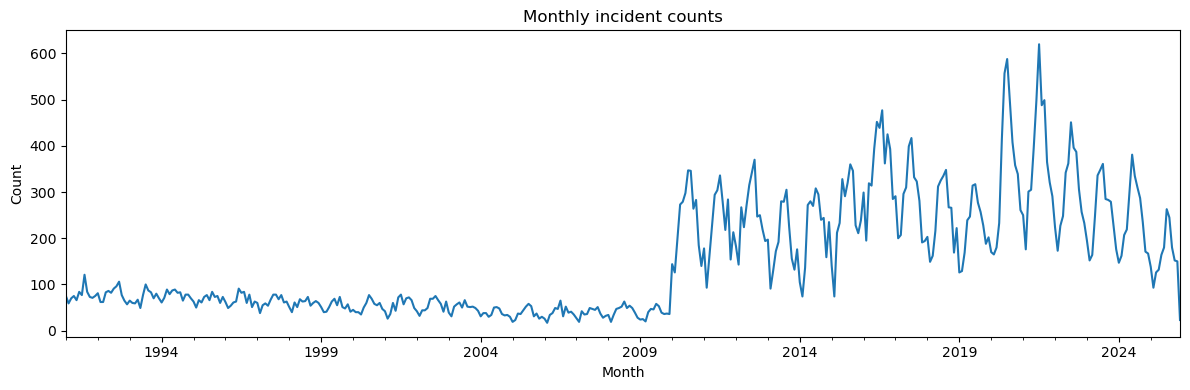

In [14]:
df['incident_timestamp'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
ts = df.set_index('incident_timestamp').resample('M').size().rename('count')
plt.figure(figsize=(12,4))
ts.plot()
plt.title('Monthly incident counts')
plt.xlabel('Month'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

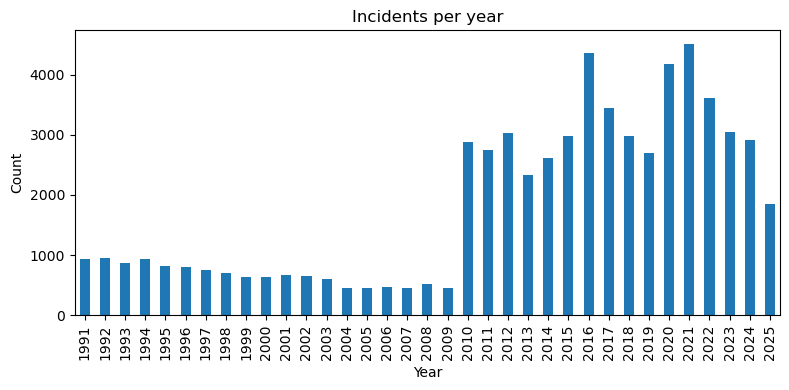

In [15]:
year_counts = df['year_char'].value_counts().sort_index()
plt.figure(figsize=(8,4))
year_counts.plot(kind='bar')
plt.title('Incidents per year')
plt.xlabel('Year'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

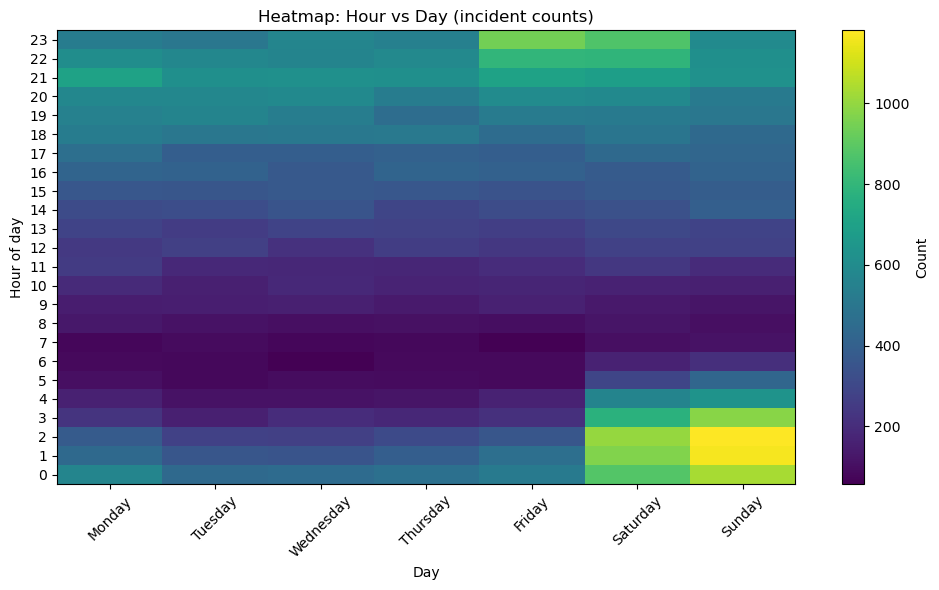

In [16]:
df['day_name'] = df['incident_timestamp'].dt.day_name()
pivot = df.pivot_table(index='HOUR', columns='day_name', values='UNIQUE_ID', aggfunc='count').fillna(0)

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot[order]

plt.figure(figsize=(10,6))
plt.imshow(pivot, aspect='auto', origin='lower')
plt.colorbar(label='Count')
plt.xticks(range(len(order)), order, rotation=45)
plt.yticks(range(0,24), range(0,24))
plt.title('Heatmap: Hour vs Day (incident counts)')
plt.xlabel('Day'); plt.ylabel('Hour of day')
plt.tight_layout()
plt.show()

In [21]:
sample = df.dropna(subset=['LATITUDE','LONGITUDE']).sample(min(5000, len(df.dropna(subset=['LATITUDE','LONGITUDE']))))

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
for _, r in sample.iterrows():
    folium.CircleMarker([r['LATITUDE'], r['LONGITUDE']],
                        radius=2,
                        popup=str(r['INCIDENT_PRIMARY']) + " | " + str(r['DATE']),
                        fill=True, opacity=0.6).add_to(m)

m.save('map_sample_1.html')


In [26]:
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)
for _, r in sample.iterrows():
    folium.Marker([r['LATITUDE'], r['LONGITUDE']],
                  popup=f"{r['INCIDENT_PRIMARY']} | {r['DATE']}").add_to(marker_cluster)
m.save('map_sample_2.html')


In [24]:
coords = df[['LATITUDE','LONGITUDE']].dropna().to_numpy()
db = DBSCAN(eps=0.005, min_samples=20).fit(coords)
labels = db.labels_

df_loc = df.dropna(subset=['LATITUDE','LONGITUDE']).copy()
df_loc['cluster'] = labels

cluster_counts = df_loc['cluster'].value_counts().head(10)
print(cluster_counts)


cluster
 0    61528
-1      792
 1      234
 2      143
 3       50
 7       32
 6       28
 8       27
 4       25
 5       18
Name: count, dtype: int64


In [25]:
sample = df_loc[df_loc['cluster']!=-1].sample(min(2000,len(df_loc[df_loc['cluster']!=-1])))
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
colors = ['red','blue','green','purple','orange','darkred','lightred','beige','darkblue','darkgreen']
for _, r in sample.iterrows():
    cl = int(r['cluster']) % len(colors)
    folium.CircleMarker([r['LATITUDE'], r['LONGITUDE']], radius=2, color=colors[cl], fill=True).add_to(m)
m.save('map_sample_3.html')

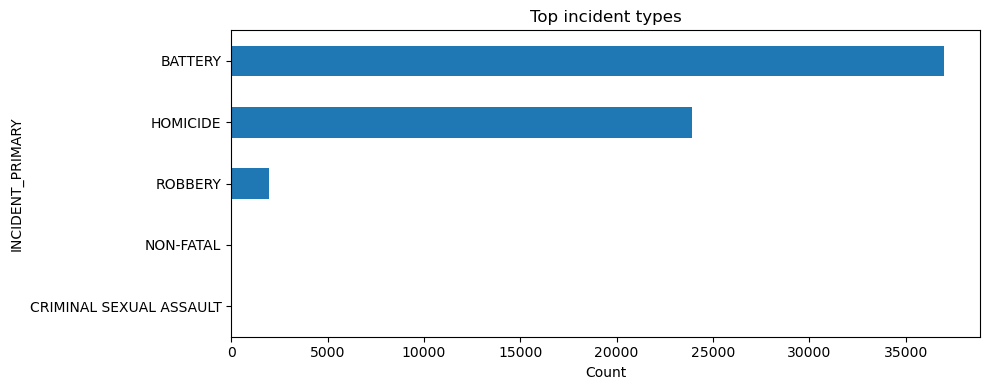

In [27]:
top_inc = df['INCIDENT_PRIMARY'].value_counts().nlargest(15)
plt.figure(figsize=(10,4))
top_inc.plot(kind='barh')
plt.title('Top incident types'); plt.xlabel('Count'); plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


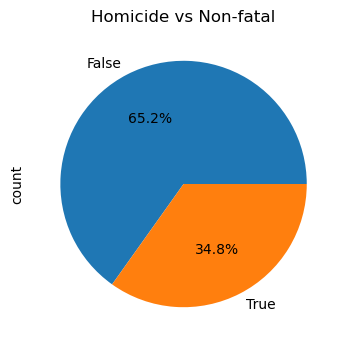

In [28]:
if 'VICTIMIZATION_PRIMARY' in df.columns:
    df['is_homicide'] = df['VICTIMIZATION_PRIMARY'].str.contains('HOMICIDE', case=False, na=False)
    df['is_homicide'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4), title='Homicide vs Non-fatal')
    plt.show()

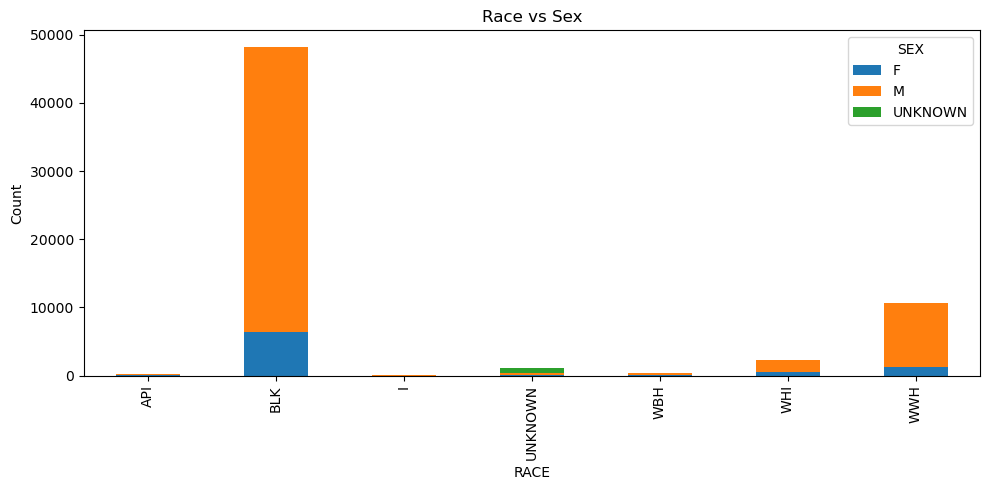

In [29]:
ct = pd.crosstab(df['RACE'], df['SEX'])
ct.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Race vs Sex'); plt.ylabel('Count')
plt.tight_layout()
plt.show()


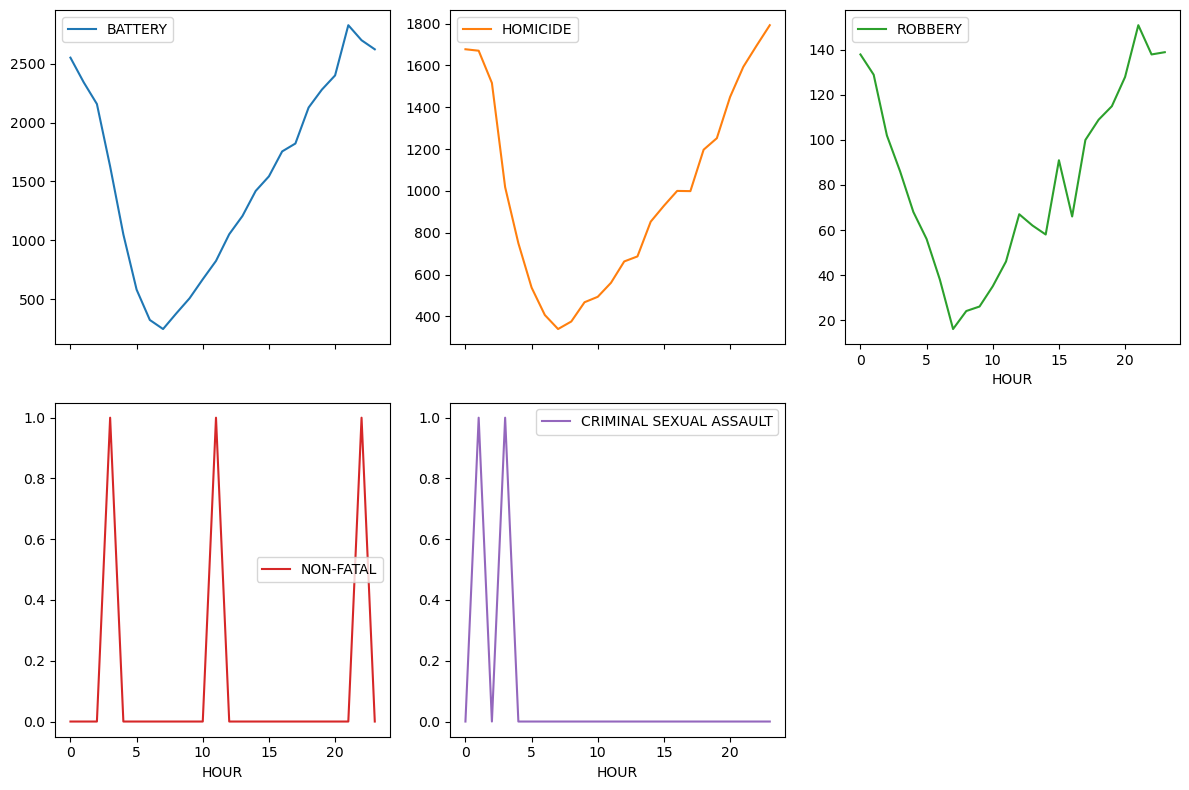

In [30]:
top_types = df['INCIDENT_PRIMARY'].value_counts().nlargest(6).index.tolist()
sub = df[df['INCIDENT_PRIMARY'].isin(top_types)]
pivot = sub.pivot_table(index='HOUR', columns='INCIDENT_PRIMARY', values='UNIQUE_ID', aggfunc='count').fillna(0)
pivot[top_types].plot(subplots=True, layout=(2,3), figsize=(12,8), sharex=True, sharey=False)
plt.tight_layout()

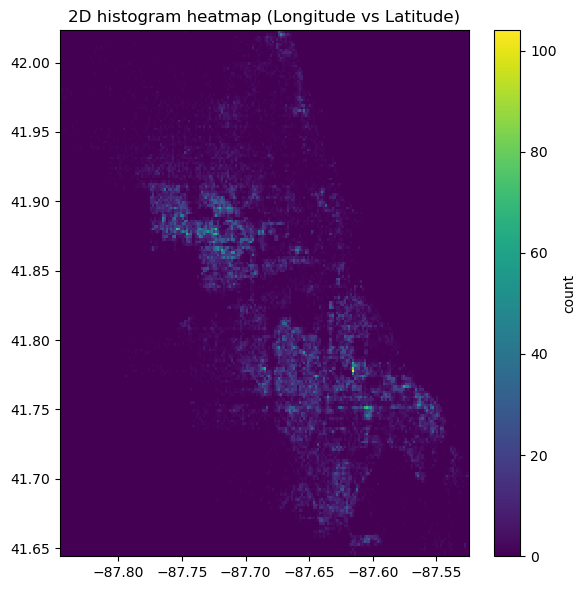

In [31]:
pts = df.dropna(subset=['LATITUDE','LONGITUDE'])
x = pts['LONGITUDE'].values
y = pts['LATITUDE'].values

plt.figure(figsize=(6,6))
plt.hist2d(x, y, bins=200)
plt.colorbar(label='count')
plt.title('2D histogram heatmap (Longitude vs Latitude)')
plt.tight_layout()
plt.show()


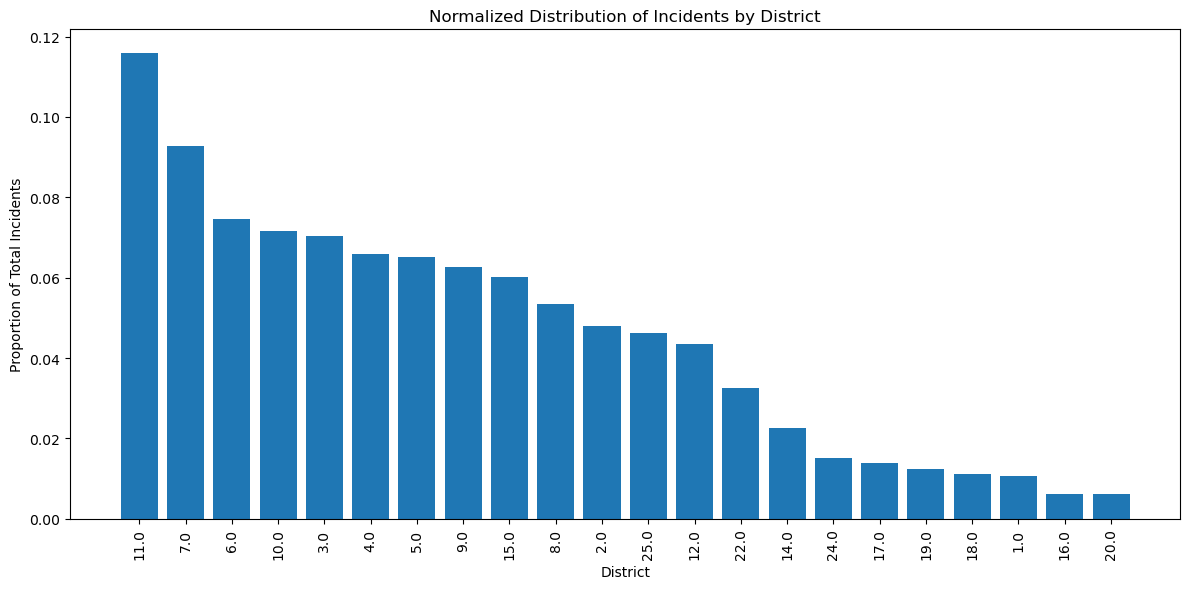

In [37]:
district_counts = (
    df[df["DISTRICT"].notna()]
    .groupby("DISTRICT")
    .size()
    .reset_index(name="count")
)

district_counts["normalized"] = (
    district_counts["count"] / district_counts["count"].sum()
)

district_counts = district_counts.sort_values("normalized", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(district_counts["DISTRICT"].astype(str),
        district_counts["normalized"])

plt.xlabel("District")
plt.ylabel("Proportion of Total Incidents")
plt.title("Normalized Distribution of Incidents by District")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


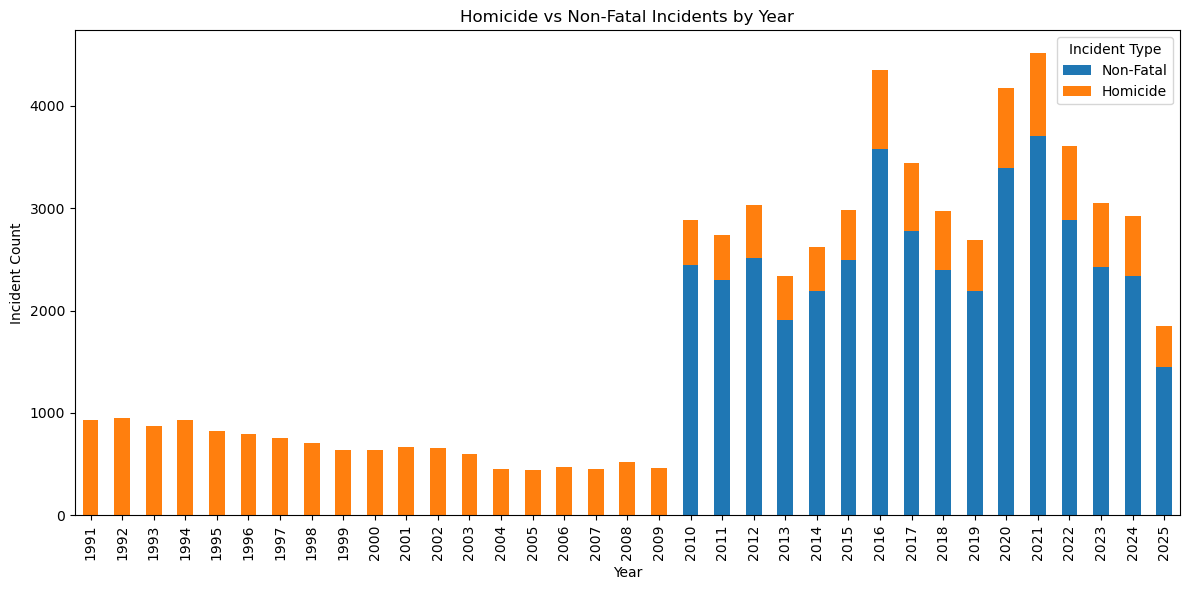

In [38]:
df["is_homicide"] = df["VICTIMIZATION_PRIMARY"] \
    .str.contains("HOMICIDE", case=False, na=False)

year_homicide = (
    df.groupby(["year_char", "is_homicide"])
      .size()
      .unstack(fill_value=0)
)

year_homicide.columns = ["Non-Fatal", "Homicide"]

year_homicide.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6)
)

plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.title("Homicide vs Non-Fatal Incidents by Year")
plt.legend(title="Incident Type")
plt.tight_layout()
plt.show()


In [57]:
query_ml = """
SELECT
    "AGE",
    "SEX",
    "RACE",
    "DISTRICT",
    "HOUR",
    "MONTH",
    "VICTIMIZATION_PRIMARY"
FROM public.violence_victims_raw
WHERE "AGE" IS NOT NULL
  AND "SEX" IS NOT NULL
  AND "RACE" IS NOT NULL
  AND "DISTRICT" IS NOT NULL
  AND "HOUR" IS NOT NULL
  AND "MONTH" IS NOT NULL;
"""

with engine.connect() as conn:
    ml_df = pd.read_sql(query_ml, conn)


ml_df["is_homicide"] = ml_df["VICTIMIZATION_PRIMARY"] \
    .str.contains("HOMICIDE", case=False, na=False).astype(int)

ml_df.drop(columns=["VICTIMIZATION_PRIMARY"], inplace=True)

X = ml_df.drop(columns=["is_homicide"])
y = ml_df["is_homicide"]

cat_cols = ["SEX", "RACE", "AGE"]
num_cols = ["DISTRICT", "HOUR", "MONTH"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



              precision    recall  f1-score   support

           0       0.66      0.98      0.79     10244
           1       0.63      0.08      0.14      5478

    accuracy                           0.66     15722
   macro avg       0.65      0.53      0.47     15722
weighted avg       0.65      0.66      0.57     15722

ROC-AUC: 0.5816555597990984


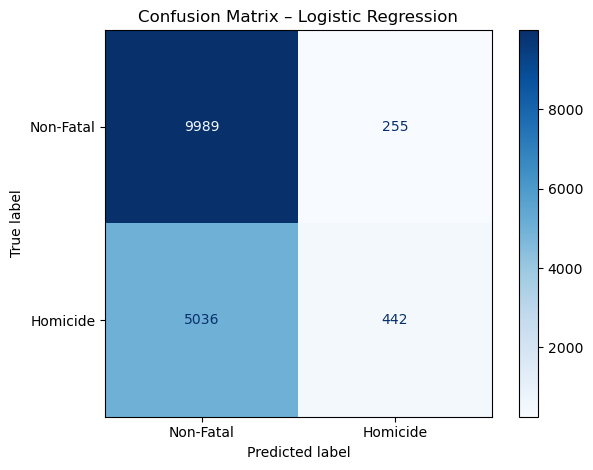

In [53]:
ConfusionMatrixDisplay.from_estimator(
    log_reg, X_test, y_test,
    display_labels=["Non-Fatal", "Homicide"],
    cmap="Blues"
)
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()

In [54]:
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        class_weight="balanced"
    ))
])
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:,1]
print("RF ROC-AUC:", roc_auc_score(y_test, rf_prob))


RF ROC-AUC: 0.6122683823932983
